# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00           2019-03-07      3   
1             7   3350000.0       40.40           2018-12-04      1   
2            10   5196000.0       56.00           2015-08-20      2   
3             0  64900000.0      159.00           2015-07-24      3   
4             2  10000000.0      100.00           2018-06-19      2   
5            10   2890000.0       30.40           2018-09-10      1   
6             6   3700000.0       37.30           2017-11-02      1   
7             5   7915000.0       71.60           2019-04-18      2   
8            20   2900000.0       33.16           2018-05-23      1   
9            18   5400000.0       61.00           2017-02-26      3   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0        51.00      8          NaN   False   
1             NaN          11.0        18.60      1          NaN  

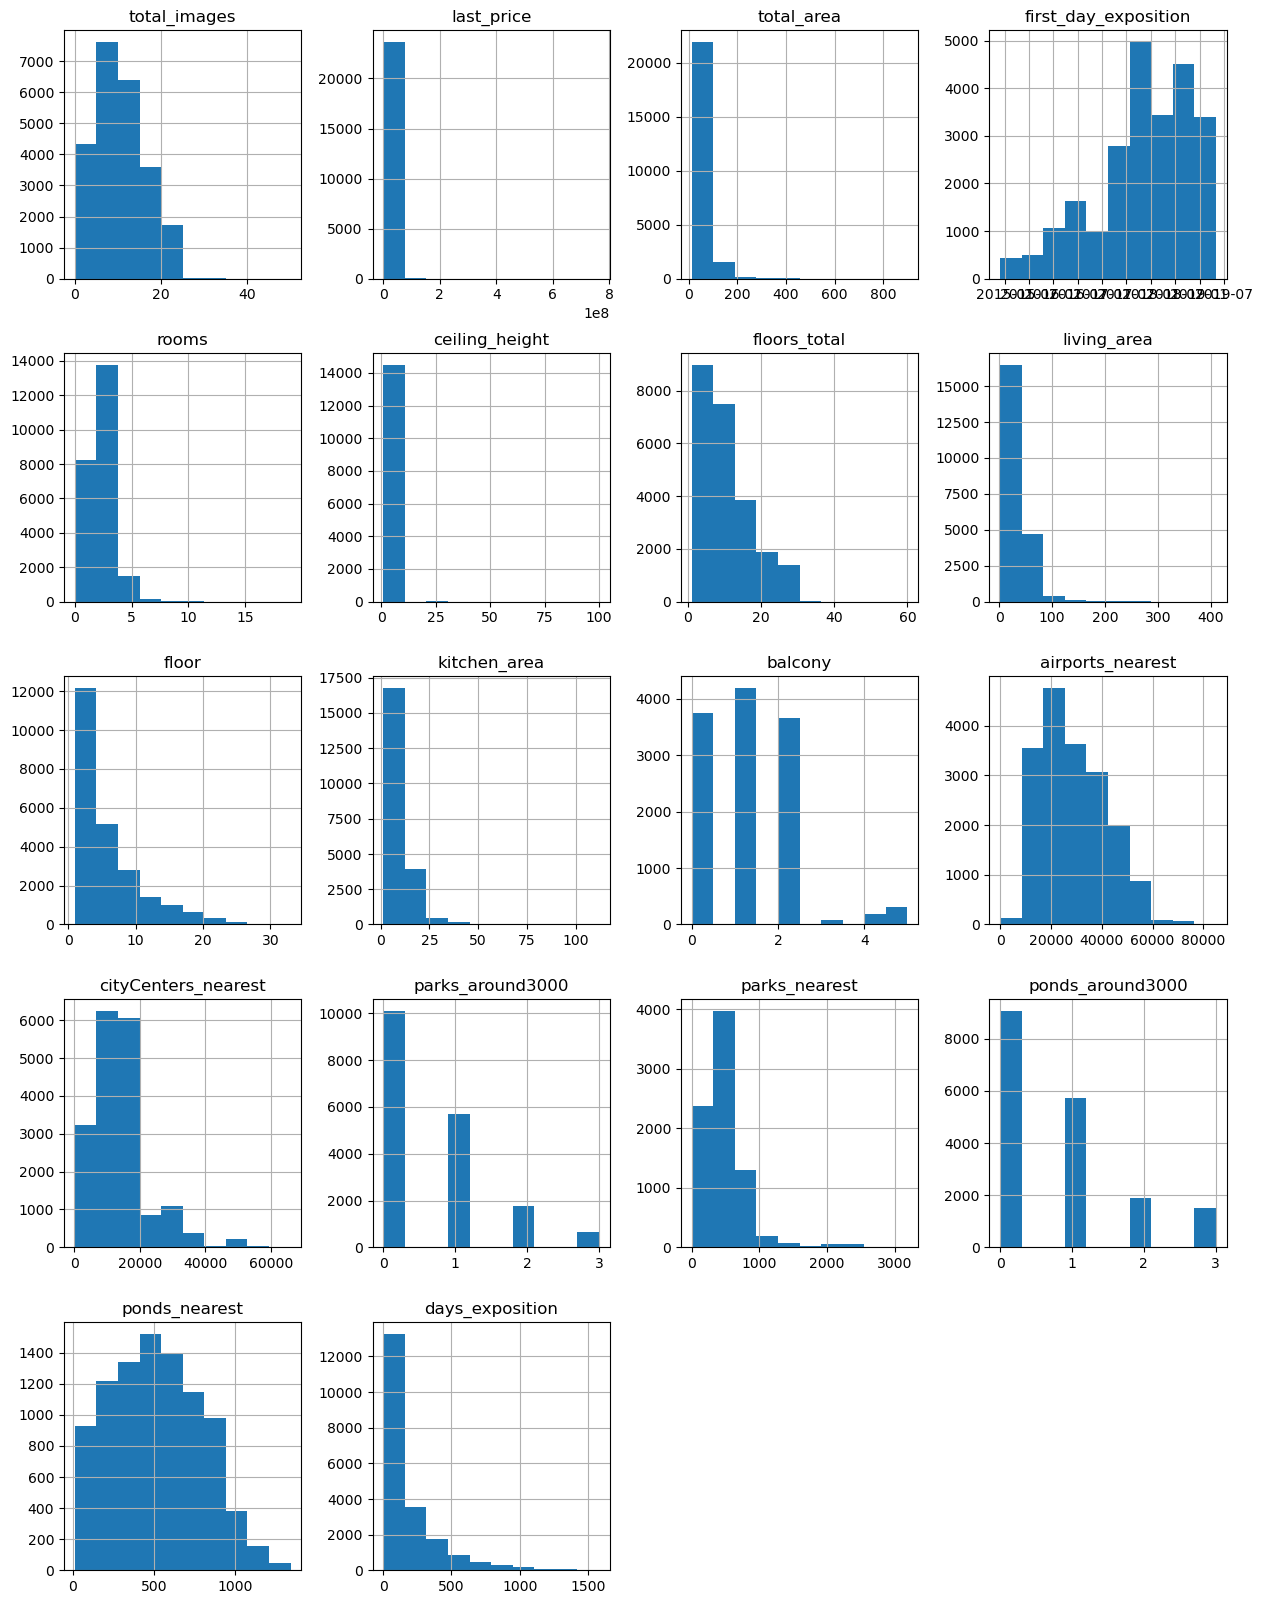

In [2]:
try:
    realty_df = pd.read_csv ('/datasets/real_estate_data.csv', sep = '\t', parse_dates=['first_day_exposition'])
except:
    realty_df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv',\
                            sep = '\t', parse_dates=['first_day_exposition'])

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
print (realty_df.head (10))
print (realty_df.info ())
print (realty_df.hist(figsize=(15, 20)))

## Предобработка данных

In [3]:
realty_df.isna ().sum ()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

посчитали сколько пропусков и в каких столбцах. Сразу можно отметить пропуски в столбцах с указанием объектов в округе и расстояние до них (аэропорт, парки, водоемы) значение практически совпали. отсутствие значений в столбце высота потолков, явно невозможно (будем рассматривать и решать, чем заполнить). Аналогичная ситуация с названием н.п., количеством этажей, жилой площадью. Столбец апартаменты - необходимо посмотреть в каких строках пропуски, предварительное предположение, что пропуск в квартирах без статуса апарты. будем разбивать выполнение задание на куски, начнем с очевидных пропусков и будем проводить обработку данных.

### Адреса.
начнем с адреса. для начала посмотрим на объекты с пропущенными адресами. всего пропущено 49 адресов, учитывая, что в данном случае обогатить адреса в моменте не представляется возможным, а прямой связи не видно в части пропусков адресов,  принимаю решение удалить 49 строк из ДФ, а также проводим корректировку названий, встречается разное написание (поселок/посёлок)

In [4]:
realty_df ['locality_name'].isnull ().sum ()

realty_df = realty_df.dropna (subset = ['locality_name']).reset_index(drop=True)

realty_df ['locality_name'] = realty_df ['locality_name'].str.lower ()

def uniq_name (data):
    row = data ['locality_name']
    if 'посёлок станции' in row:
        return row.replace ('посёлок станции ', '')
    elif 'поселок станции' in row:
        return row.replace ('поселок станции ', '')
    elif 'посёлок городского типа' in row:
        return row.replace ('посёлок городского типа ', '')
    elif 'поселок городского типа' in row:
        return row.replace ('поселок городского типа ', '')
    elif 'деревня' in row:
        return row.replace ('деревня ', '')
    elif 'городской посёлок' in row:
        return row.replace ('городской посёлок ', '')
    elif 'городской поселок' in row:
        return row.replace ('городской поселок ', '')
    elif 'пок городского типа' in row:
        return row.replace ('пок городского типа ', '')
    elif 'садоводческое некоммерческое товарищество ' in row:
        return row.replace ('садоводческое некоммерческое товарищество ', '')
    elif 'коттеджный посёлок' in row:
        return row.replace ('коттеджный посёлок ', '')
    elif 'коттеджный поселок' in row:
        return row.replace ('коттеджный поселок ', '')
    elif 'коттеджный ' in row:
        return row.replace ('коттеджный ', '')
    elif 'садовое товарищество' in row:
        return row.replace ('садовое товарищество ', '')
    elif 'посёлок при железнодорожной станции' in row:
        return row.replace ('посёлок при железнодорожной станции ', '')
    elif 'поселок ' in row:
        return row.replace ('поселок ', '')
    elif 'посёлок' in row:
        return row.replace ('посёлок ', '')
    elif 'пок' in row:
        return row.replace ('пок ', '')
    elif 'село' in row:
        if 'Красное село' in row:
            return row
        else:
            return row.replace ('село ', '')
    else:
        return row
    
realty_df ['locality_name'] = realty_df.apply (uniq_name, axis=1)


realty_df ['locality_name'].unique ()

array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красный бор', 'гатчина', 'фёдоровское',
       'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное село', 'понтонный',
       'сясьстрой', 'старая', 'лесколово', 'новый свет', 'сланцы',
       'путилово', 'ивангород', 'шлиссельбург', 'никольское',
       'зеленогорск', 'сосновый бор', 'оржицы', 'кальтино', 'романовка',
       'бугры', 'рощино', 'кириши', 'луга', 'волосово', 'отрадное',
       'павлово', 'оредеж', 'копорье', 'молодёжное', 'тихвин', 'победа',
       'нурма', 'синявино', 'тосно', 'стрельна', 'бокситогорск',

### Аппартаменты.
Посмотрим на значение апартаменты. данное поле является категоричным, бул.значения - или да или нет. Значения пропущены в 20890 ячейках. Так как апартаменты являются коммерческой недвижимостью, и по своей сущности не могут иметь жилой площади, необходимо провести исследование, в котором сопоставим значения из столбца жилой площади и апартаментов. Так как в ячейках жилой площади нет значений 0, но есть пропуски, берем за допущение что все значения с пропусками это 0. (прим. пропусков в разделе общей площади нет). После этого у нас останется часть объектов не апартов с жилой площадью 0, к ним вернемся после оценки раздела с кухнями.
справочный материал по апартаментам https://journal.tinkoff.ru/opasnosti-apartamentov/


In [5]:
print (realty_df ['is_apartment'].value_counts (dropna=False))

realty_df ['is_apartment'] = realty_df ['is_apartment'].fillna(True)
print (realty_df ['is_apartment'].value_counts (dropna=False))

realty_df ['living_area'] = realty_df ['living_area'].fillna (0)
print (realty_df ['living_area'].value_counts (dropna=False))

def match (row):
    value1= row ['living_area']
    value2= row ['is_apartment']
    try:
        if value1==0 and value2 == True:
            return True
        else:
            return False
    except:
        return 'Error'

realty_df ['analysis_apart'] = realty_df.apply (match, axis=1)
realty_df['analysis_apart'].value_counts ()

is_apartment
NaN      20890
False     2710
True        50
Name: count, dtype: int64
is_apartment
True     20940
False     2710
Name: count, dtype: int64
living_area
0.00      1898
18.00      882
17.00      674
30.00      598
16.00      485
          ... 
28.86        1
76.70        1
39.41        1
124.90       1
42.55        1
Name: count, Length: 1783, dtype: int64


analysis_apart
False    21862
True      1788
Name: count, dtype: int64

In [6]:
realty_df['locality_name'].replace('d', 'fr')

0        санкт-петербург
1                 шушары
2        санкт-петербург
3        санкт-петербург
4        санкт-петербург
              ...       
23645    санкт-петербург
23646              тосно
23647        рождествено
23648    санкт-петербург
23649        новый учхоз
Name: locality_name, Length: 23650, dtype: object

### Балконы.

Теперь разберёмся с объектами, в столбце "жилая площадь" мы проставили 0, но они не попали под категорию апартаментов. Пропусков у нас больше нет, но 1898 объектов с значением 0. Но для начала нужно разобраться с балконами, так каких площадь входит в общую площадь (примем за допущение коэффициент расчета отношения площади балкона/лоджии равный 0 - в общую входит, в жилую нет (Прим. в законодательстве предусмотрен расчет: лоджии 0.5, балконы 0.3 от общей площади последних относится к жилой). Если количество балконов не указано - принимаем что их нет. также сразу заменим тип столбца на целое
Замена типа данных обусловлена целочисленным значением объекта "Балкон"


In [7]:
realty_df ['balcony'].value_counts (dropna=False)
realty_df ['balcony'] = realty_df ['balcony'].fillna (0).astype (int)
realty_df ['balcony'].value_counts (dropna=False)

balcony
0    15238
1     4187
2     3658
5      304
4      182
3       81
Name: count, dtype: int64

### Квартиры с большим количеством балконов.
В таблице есть объекты, в которых больше 3 балконов, что выглядит странным. посмотрим на эти квартиры. Было бы странно, если в квартире на 40 кв.м. 5 балконов. Аномальных квартир менее 50-ти. Считаю возможным исключить из ДФ объекты в которых более 3-х балконов, даже при допущении такой ситуации, их количество не должно сильно повлиять на итоговые данные.

In [8]:
realty_df = realty_df.query ('balcony <= 3').reset_index(drop=True)
print (realty_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23164 entries, 0 to 23163
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23164 non-null  int64         
 1   last_price            23164 non-null  float64       
 2   total_area            23164 non-null  float64       
 3   first_day_exposition  23164 non-null  datetime64[ns]
 4   rooms                 23164 non-null  int64         
 5   ceiling_height        14118 non-null  float64       
 6   floors_total          23079 non-null  float64       
 7   living_area           23164 non-null  float64       
 8   floor                 23164 non-null  int64         
 9   is_apartment          23164 non-null  bool          
 10  studio                23164 non-null  bool          
 11  open_plan             23164 non-null  bool          
 12  kitchen_area          20908 non-null  float64       
 13  balcony         

### Высота потолков.
9195 пропусков. Значение обязательно должны быть. разберемся со значениями выбросами в высоте потолков. Исходя из понимания, что согласно нормам в НПА, высота потолка в самых теплых помещениях составляет не менее 2,7 метра, а в остальных помещениях — не менее 2,5 метра, учитывая распространение навесных потолков (-15/20 см от общей высоты), все что менее 2.3  метров (норма до 2.5m минус 15/20 см на подвесной потолок), считаю выбросом, что подтверждается границами 1 квартили по высоте потолка, что выше 4 м аномалия. посмотрим сколько таких квартир в ДФ. Всего 75 квартир с высотой потолков выше 4 метров, несмотря на возможность потолков 4+, но оставшиеся значения или выглядят как аномалия (высота в 100 метров) или возможно квартиры старого фонта (постройки 50-х годов), что тоже маловероятно для региона и н.п.. Принимаю решение допустимости исключения данных объектов из итогового ДФ

Значение медианы выглядит логично - 2,65.  Прихожу к пониманию, что пропуски можно заменить медианой. 

In [9]:
#print (realty_df ['ceiling_height'].describe())
#print (realty_df.plot (y='ceiling_height', kind='hist', range=(0, 5), bins=50))

height_median = realty_df ['ceiling_height'].median()
realty_df ['ceiling_height_stat'] = realty_df ['ceiling_height'].fillna (height_median)

# пропусков в разделе высоты потолков больше нет - столбец ceiling_height_stat         
realty_df.isna ().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9046
floors_total               85
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2256
balcony                     0
locality_name               0
airports_nearest         5434
cityCenters_nearest      5411
parks_around3000         5410
parks_nearest           15284
ponds_around3000         5410
ponds_nearest           14260
days_exposition          3085
analysis_apart              0
ceiling_height_stat         0
dtype: int64

In [10]:
realty_df = realty_df.query ('2.3 <= ceiling_height_stat <= 4.0').reset_index(drop=True)
realty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23077 entries, 0 to 23076
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23077 non-null  int64         
 1   last_price            23077 non-null  float64       
 2   total_area            23077 non-null  float64       
 3   first_day_exposition  23077 non-null  datetime64[ns]
 4   rooms                 23077 non-null  int64         
 5   ceiling_height        14031 non-null  float64       
 6   floors_total          22992 non-null  float64       
 7   living_area           23077 non-null  float64       
 8   floor                 23077 non-null  int64         
 9   is_apartment          23077 non-null  bool          
 10  studio                23077 non-null  bool          
 11  open_plan             23077 non-null  bool          
 12  kitchen_area          20836 non-null  float64       
 13  balcony         

### Кухня.

в столбце кухня пропуски в 2269 ячейках, исходя из понимания, что в студиях кухни как отдельной зоны нет, и могут соответственно не указывать, так как зона кухни входит в общую зону, заменим значением 0 все ячейки для студий. Перед манипуляциями сохраним медиану в отдельную переменную (предварительно просмотрели- медиана 9.1 кв.м. что близко к жизни). Сейчас  149 студий в списке. После замены пропусков заглушкой 9999, проверили, что ДФ не было студий с параметром размера кухни, и все пропуски студия+значение размера кухни стали 9999. 
Теперь можем заменить заглушку в студиях размер кухни на 0, а остальных помещениях на медиану. Создав новый столбец kitchen_stat_norm. Изучив данные после замен, один объект выбивается на мой взгляд, № 504 - кухня 50 кв.м.+жилая 13, а общая площадь 69. Примем за допущение (возможно евродвушка, где 1 жилая комната, а второе помещение - кухня совмещенная со столовой)


In [11]:
#print (realty_df.sort_values(by='kitchen_area', ascending = False))
#print (realty_df ['kitchen_area'].describe())
kitchen_median = realty_df ['kitchen_area'].median ()
realty_df ['kitchen_area'] = realty_df ['kitchen_area'].fillna (9999)

realty_df.query ('studio==True & kitchen_area !=9999').value_counts()

realty_df ['kitchen_stat_norm'] = realty_df ['kitchen_area'].where (realty_df['studio'] == False, 0)
realty_df ['kitchen_stat_norm'] = realty_df ['kitchen_stat_norm'].where (realty_df ['kitchen_stat_norm']!=9999, kitchen_median)

realty_df ['kitchen_stat_norm'].value_counts()
realty_df.query ('kitchen_stat_norm >45').groupby ('total_area').head ()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,analysis_apart,ceiling_height_stat,kitchen_stat_norm
49,7,45000000.0,161.0,2017-10-17,3,3.20,8.0,38.00,4,True,False,False,50.0,0,санкт-петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0,False,3.20,50.0
474,18,95000000.0,216.0,2017-12-05,4,3.00,5.0,86.00,4,True,False,False,77.0,0,санкт-петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0,False,3.00,77.0
493,7,5950000.0,69.0,2017-12-21,1,NaN,16.0,13.00,12,True,False,False,50.0,1,мурино,NaN,NaN,NaN,NaN,NaN,NaN,56.0,False,2.65,50.0
635,10,18500000.0,131.0,2018-10-11,3,2.80,20.0,64.00,19,True,False,False,50.0,0,санкт-петербург,39771.0,8672.0,1.0,139.0,0.0,NaN,53.0,False,2.80,50.0
769,20,135000000.0,310.0,2018-05-22,4,3.30,5.0,250.00,2,True,False,False,50.0,0,санкт-петербург,34159.0,7251.0,2.0,295.0,3.0,190.0,342.0,False,3.30,50.0
1053,16,75000000.0,323.0,2017-07-10,5,4.00,5.0,255.70,4,True,False,False,66.0,0,санкт-петербург,23713.0,594.0,3.0,398.0,2.0,515.0,259.0,False,4.00,66.0
1647,20,20500000.0,168.0,2015-09-20,4,3.00,5.0,72.52,2,True,False,False,46.0,0,санкт-петербург,17112.0,16114.0,3.0,574.0,2.0,207.0,NaN,False,3.00,46.0
2121,8,23990000.0,153.0,2015-12-18,4,2.80,25.0,75.00,12,True,False,False,46.0,0,санкт-петербург,51333.0,13056.0,0.0,NaN,0.0,NaN,1179.0,False,2.80,46.0
2301,11,50000000.0,128.0,2016-06-24,3,NaN,9.0,42.00,1,True,False,False,50.0,0,санкт-петербург,26933.0,5780.0,1.0,625.0,1.0,283.0,27.0,False,2.65,50.0
2429,9,12500000.0,255.0,2017-04-21,3,NaN,2.0,153.90,2,True,False,False,100.7,0,санкт-петербург,29544.0,6916.0,0.0,NaN,3.0,198.0,102.0,False,2.65,100.7


### Комнаты. 

Квартиры, в которых количество комнат более 6-ти, всего 86, в целом данные квартиры можно отнести к категории - аномалии. Удаляем

In [12]:
realty_df = realty_df.query ('rooms<=6').reset_index (drop=True)

### Студии.

Исходя из понимания, что в студиях не может быть комнаты, поэтому в разделе комнаты у студии должно быть указано 0. студий у нас в списке 144, объектов с указанием что комнат 0 - 190, нужно посмотреть, входят ли все студии в список объектов без комнат, и если - да, посмотреть какие объекты не студии, но без комнат. По указанному сочетанию получили 133 объекта, оставшиеся студии указаны как однокомнатные, с общей площадью не более 32.5 кв.м., с высокой долей вероятности эти 11 студий, по какой-то причине указали с комнатами - исправим это. Также обращаем внимание, что в список попала апартаменты с площадью 370 кв.м. без указания количества комнат, учитывая единичный случай, их можно удалить из ДФ

В оставшемся ДФ, 56 объектов с общей площадью менее 45 кв.м. без указания комнат, учитывая площадь, могу с высокой долей вероятности предположить, что это квартиры студии, проведем корректировку статуса студий. Итого в ДФ стало 200 студий


In [13]:
def room_studio (data, task):
    try:
        room=data ['rooms']
        studio = data ['studio']
        if task==0:
            if studio == True:
                        
                return 0
            else:
                return room
        if task==1:
            if room == 0:
                studio = True
                return studio
            else:
                studio = False
                return studio
        
    except:
        return 'Error'
            

realty_df ['rooms'] = realty_df.apply (room_studio, task=0, axis=1)
realty_df ['rooms'] = realty_df ['rooms'].astype (int)
realty_df=realty_df.query ('total_area !=371.00')
realty_df ['studio'] = realty_df.apply (room_studio, task=1, axis=1)
zero_not_studio = realty_df.query ('rooms==0 & studio == True')
realty_df ['rooms']. value_counts ()

rooms
1    7961
2    7758
3    5525
4    1130
5     309
0     205
6     102
Name: count, dtype: int64

### Жилая площадь
отсутствующие значения жилой площади (забендины 0), исключив апарты и студии из расчета, можно заполнить средним размером комнат к жилой площади уже нам известной (возьмем сумму всей жилой площади (0 не добавят объема), без апартов и студий, и разделим на общее количество комнат в ДФ)

Мы получили коэффициент в размере 16.4 кв.м. на 1 комнату в средней статистике, заполним таблицу исходя из этих данных и количества комнат



In [14]:
live_area_filltred = realty_df.query ('(analysis_apart!=True) & (studio!=True)')
summa_room = live_area_filltred ['rooms'].sum ()
summa_living_area = live_area_filltred ['living_area'].sum ()
ratoin_living_area = round (summa_living_area/summa_room, 1)


def add_living_area (data, ratio):
    try:
        area = data ['living_area']
        rooms = data ['rooms']
        
        if area > 0:
            return area
        else:
            area = rooms*ratoin_living_area
            return area
        
    except:
        return 'Error'

realty_df ['living_area'] = realty_df.apply (add_living_area, ratio=ratoin_living_area,  axis=1)



### Этажи.

в столбце этажи 85 пропусков. Можно предположить, что пропуски связаны с тем, что это частные дома, и там нет этажей, но для начала проверим какие значения есть в разделе этажей. Необходимо не забывать, что если указано что этаж размещения объекта выше 1, то с высокой долей вероятности пропуск значения в разделе этажности - ошибка.
Медиана = 9-ти этажные здания, но есть и 30+ этажность, в санкт-петербурге есть здание в котором 87 этажей, но средняя застройка в высотках редко бывает выше 28 этажей, посмотрим, что за объекты с этажами выше 28 и где они расположены. Итого 2 квартиры выше 28-го этажа, что менее 0,001% - прихожу к выводу, что можно удалить. (статья https://lenobldoma.ru/doma-po-etazham) 

Заменим тип данных на целое. Прим (сейчас вещественное, поменяем на целое, этажи в домах в подавляющем большинстве целое значение)


In [15]:
realty_df ['floors_total'].value_counts (dropna=False, ascending=False)
realty_df ['floors_total'].describe()
print (realty_df.query('floors_total > 28').value_counts().sum ())
realty_df = realty_df.query('floors_total <= 28').reset_index(drop=True)

realty_df ['floors_total'] = realty_df ['floors_total'].astype (int)


#проверим на пропуски в этажности оставшиеся данные ДФ - пропусков больше нет.
print (realty_df.isnull().sum())



2
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           8927
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5396
cityCenters_nearest      5376
parks_around3000         5375
parks_nearest           15134
ponds_around3000         5375
ponds_nearest           14142
days_exposition          3026
analysis_apart              0
ceiling_height_stat         0
kitchen_stat_norm           0
dtype: int64


### Удалим явные дубли.
    

In [16]:
realty_df = realty_df.drop_duplicates().reset_index(drop=True)
realty_df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           8927
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5396
cityCenters_nearest      5376
parks_around3000         5375
parks_nearest           15134
ponds_around3000         5375
ponds_nearest           14142
days_exposition          3026
analysis_apart              0
ceiling_height_stat         0
kitchen_stat_norm           0
dtype: int64

### Инфраструктура 
попробуем разобраться с инфраструктурой. одним из решений вижу возможность пропуски дозаполнить средними значениями для отдельно взятого н.п. для начала нам нужна сводная таблица средних расстояний для каждого н.п. (Прим. заменим типы данных на целые). Примененные способы группировки и использования значений заглушек подвели меня к пониманию, что данное значение можем оставить без заполнения пропусков. Обоснование: во-первых, данные предоставлены сервисом Яндекс.Недвижимость, соответственно использование сведений от Яндекс.Карты не вызывало бы сложностей при формирование реестра (ошибки в пропусках маловероятны), во-вторых, сведений о расстоянии и количестве объектов может не быть, потому что их просто нет рядом (в списке различные СТН, деревни и т.п.) Учитывая все изыскания, и указанное выше, использовав в качестве заглушки -77, и сменив формат на целочисленное (для расстояния не критично опустить метры, а прудов и парков не может быть не целое число), идем дальше.

In [17]:
# сохраним в переменную название всех городов
sity_name = realty_df ['locality_name'].unique ()
realty_df[['parks_around3000','airports_nearest','parks_nearest','ponds_around3000',\
           'ponds_nearest']] = realty_df[['parks_around3000','airports_nearest','parks_nearest',\
                                          'ponds_around3000','ponds_nearest']].fillna(-77)
# сгруппируем по названию н.п. таблицу с параметрами инфраструктуры
realty_group_sity = realty_df.groupby ('locality_name') [['parks_around3000','airports_nearest',\
                                                          'parks_nearest','ponds_around3000','ponds_nearest']].agg ('median')
realty_group_sity.head (25)
realty_df = realty_df.astype({'parks_around3000': np.int64, 'airports_nearest': np.int64,\
                              'parks_nearest': np.int64,'ponds_around3000': np.int64,'ponds_nearest': np.int64})
realty_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22874 entries, 0 to 22873
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22874 non-null  int64         
 1   last_price            22874 non-null  float64       
 2   total_area            22874 non-null  float64       
 3   first_day_exposition  22874 non-null  datetime64[ns]
 4   rooms                 22874 non-null  int32         
 5   ceiling_height        13947 non-null  float64       
 6   floors_total          22874 non-null  int32         
 7   living_area           22874 non-null  float64       
 8   floor                 22874 non-null  int64         
 9   is_apartment          22874 non-null  bool          
 10  studio                22874 non-null  bool          
 11  open_plan             22874 non-null  bool          
 12  kitchen_area          22874 non-null  float64       
 13  balcony         

### Размещение объявление в днях
Пропуски в количестве дней размещений не критичны, так как возможно объект еще не снят с продажи. Идем дальше

### Тип этажа квартиры 
(«первый», «последний», «другой»). Создадим столбец категорий этажности и переберем все квартиры. Функции расчетов схожие, сделаем все в 1-ой

In [18]:
def setting (data, task):
    try:
        # отфильтровка блока который необходимо выполнить
########## этажи по категориям ###############
        if task==0:
            total = data['floors_total']
            floor = data['floor']
            if floor == 1:
                return 'первый'
            elif floor == total:
                return 'последний'
            else:
                return 'другой'

################ цена за 1 кв.м. ##########        
        elif task==5:
            price = data ['last_price']
            area = data ['total_area']
            ration = price/area
            return round(ration, 1)
  ##########день недели ###############      
        elif task==1:
            day = data ['first_day_exposition'].weekday ()
            if day == 0:
                return 'Понедельник'
            elif day == 1:
                return 'Вторник'
            elif day == 2:
                return 'Среда'
            elif day == 3:
                return 'Четверг'
            elif day == 4:
                return 'Пятница'
            elif day == 5:
                return 'Суббота'
            else:
                return 'Воскресенье'
 ############# месяц ########         
        elif task==2:
            date_full = data ['first_day_exposition']
            month = date_full.month
            list_month = [0, 'янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
            
            try:
                for index in range (13):
                    if index == month:
                        return list_month [index]
            except:
                return 'Error.month'
            
########  год ########            
        elif task==3:
            date_full = data ['first_day_exposition']
            year = date_full.year
            return year
            
        
    except:
        return 'Error. Total'
        
        
                
                
                        
realty_df ['floor_type'] = realty_df.apply (setting, task=0, axis=1)
realty_df ['floor_type'].value_counts()

floor_type
другой       16788
последний     3216
первый        2870
Name: count, dtype: int64

## Посчитайте и добавьте в таблицу новые столбцы

### цена 1 кв.м.
У нас есть подготовленный столбец с ценной на объект недвижимости и его общая площадь, ценная 1 кв.м. будет в их отношении

In [19]:
    
realty_df ['ration_price_area'] = realty_df.apply (setting, task=5, axis=1)
realty_df.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,analysis_apart,ceiling_height_stat,kitchen_stat_norm,floor_type,ration_price_area
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,False,False,25.0,0,санкт-петербург,18863,16028.0,1,482,2,755,NaN,False,2.70,25.0,другой,120370.4
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,True,False,False,11.0,2,шушары,12817,18603.0,0,-77,0,-77,81.0,False,2.65,11.0,первый,82920.8
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,True,False,False,8.3,0,санкт-петербург,21741,13933.0,1,90,2,574,558.0,False,2.65,8.3,другой,92785.7
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,49.2,9,True,False,False,9999.0,0,санкт-петербург,28098,6800.0,2,84,3,234,424.0,True,2.65,9.0,другой,408176.1
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,False,False,41.0,0,санкт-петербург,31856,8098.0,2,112,1,48,121.0,False,3.03,41.0,другой,100000.0


### расчет и добавление дня недели создания объявления
у нас есть столбец first_day_exposition, применим метод weekday

In [20]:

realty_df ['first_weekday'] = realty_df.apply (setting, task=1, axis=1)
realty_df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,analysis_apart,ceiling_height_stat,kitchen_stat_norm,floor_type,ration_price_area,first_weekday
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,False,False,25.0,0,санкт-петербург,18863,16028.0,1,482,2,755,NaN,False,2.70,25.0,другой,120370.4,Четверг
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,True,False,False,11.0,2,шушары,12817,18603.0,0,-77,0,-77,81.0,False,2.65,11.0,первый,82920.8,Вторник
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,True,False,False,8.3,0,санкт-петербург,21741,13933.0,1,90,2,574,558.0,False,2.65,8.3,другой,92785.7,Четверг
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,49.2,9,True,False,False,9999.0,0,санкт-петербург,28098,6800.0,2,84,3,234,424.0,True,2.65,9.0,другой,408176.1,Пятница
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,False,False,41.0,0,санкт-петербург,31856,8098.0,2,112,1,48,121.0,False,3.03,41.0,другой,100000.0,Вторник


### расчет и добавление месяца публикации объявления
Также используем first_day_exposition

In [21]:

realty_df ['month'] = realty_df.apply (setting, task=2, axis=1)
realty_df.head ()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,analysis_apart,ceiling_height_stat,kitchen_stat_norm,floor_type,ration_price_area,first_weekday,month
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,False,False,25.0,0,санкт-петербург,18863,16028.0,1,482,2,755,NaN,False,2.70,25.0,другой,120370.4,Четверг,мар
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,True,False,False,11.0,2,шушары,12817,18603.0,0,-77,0,-77,81.0,False,2.65,11.0,первый,82920.8,Вторник,дек
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,True,False,False,8.3,0,санкт-петербург,21741,13933.0,1,90,2,574,558.0,False,2.65,8.3,другой,92785.7,Четверг,авг
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,49.2,9,True,False,False,9999.0,0,санкт-петербург,28098,6800.0,2,84,3,234,424.0,True,2.65,9.0,другой,408176.1,Пятница,июл
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,False,False,41.0,0,санкт-петербург,31856,8098.0,2,112,1,48,121.0,False,3.03,41.0,другой,100000.0,Вторник,июн


### расчет и добавление года публикации объявления
Также используем first_day_exposition

In [22]:
realty_df ['year'] = realty_df.apply (setting, task=3, axis=1)
realty_df.head ()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,analysis_apart,ceiling_height_stat,kitchen_stat_norm,floor_type,ration_price_area,first_weekday,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,False,False,25.0,0,санкт-петербург,18863,16028.0,1,482,2,755,NaN,False,2.70,25.0,другой,120370.4,Четверг,мар,2019
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,True,False,False,11.0,2,шушары,12817,18603.0,0,-77,0,-77,81.0,False,2.65,11.0,первый,82920.8,Вторник,дек,2018
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,True,False,False,8.3,0,санкт-петербург,21741,13933.0,1,90,2,574,558.0,False,2.65,8.3,другой,92785.7,Четверг,авг,2015
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,49.2,9,True,False,False,9999.0,0,санкт-петербург,28098,6800.0,2,84,3,234,424.0,True,2.65,9.0,другой,408176.1,Пятница,июл,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,False,False,41.0,0,санкт-петербург,31856,8098.0,2,112,1,48,121.0,False,3.03,41.0,другой,100000.0,Вторник,июн,2018


### Центр
Сгруппируем и посмотрим на медиативные значения расстояний до центра. всего пропусков 5376, медиану смогли расчитать только для 24 городов, по остальным н.п. нет данных
Остальные пропуски заполним заглушками (-7777)

In [23]:
display (len(realty_df[realty_df['cityCenters_nearest'].isna()]))

group_sity_center = realty_df.pivot_table (index = 'locality_name',  values = 'cityCenters_nearest', aggfunc='median').astype (int).reset_index()
display (group_sity_center)
group_sity_center.info()



5376

,locality_name,cityCenters_nearest
0,александровская,27468
1,белоостров,38868
2,зеленогорск,53381
3,колпино,32018
4,красное село,29140
5,кронштадт,49572
6,левашово,25727
7,лисий нос,28226
8,ломоносов,51677
9,металлострой,27629


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   locality_name        25 non-null     object
 1   cityCenters_nearest  25 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 428.0+ bytes


In [24]:
for t in realty_df['locality_name'].unique():
    realty_df.loc[(realty_df['locality_name'] == t) & (realty_df['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    realty_df.loc[(realty_df['locality_name'] == t), 'cityCenters_nearest'].median()

смогли заполнить только 66 пропусков медиативным значением по городу, учитывая что в ДФ много небольших населенных пунктов, скорее всего в них нет понятия расстояния до центра.

In [25]:
realty_df['cityCenters_nearest'] = realty_df['cityCenters_nearest'].fillna (-7777)
realty_df['cityCenters_nearest'].isna().sum()

0

Добавим столбец среднего расстояния в км, округлим его и заменим формат на целочисленый

In [26]:
realty_df ['cityCenters_averag_km'] = round (realty_df ['cityCenters_nearest']/1000).astype (int)


## Проведите исследовательский анализ данных

### Гистограммы для обработанных параметров


пересоберем итоговую таблицу

In [27]:
realty_df_norm = realty_df.drop (columns=['ceiling_height', 'is_apartment', 'kitchen_area'], axis=1).reset_index (drop=True)
realty_df_norm.info()
realty_df_norm.isnull().sum ()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22874 entries, 0 to 22873
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   total_images           22874 non-null  int64         
 1   last_price             22874 non-null  float64       
 2   total_area             22874 non-null  float64       
 3   first_day_exposition   22874 non-null  datetime64[ns]
 4   rooms                  22874 non-null  int32         
 5   floors_total           22874 non-null  int32         
 6   living_area            22874 non-null  float64       
 7   floor                  22874 non-null  int64         
 8   studio                 22874 non-null  bool          
 9   open_plan              22874 non-null  bool          
 10  balcony                22874 non-null  int32         
 11  locality_name          22874 non-null  object        
 12  airports_nearest       22874 non-null  int64         
 13  c

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
floors_total                0
living_area                 0
floor                       0
studio                      0
open_plan                   0
balcony                     0
locality_name               0
airports_nearest            0
cityCenters_nearest         0
parks_around3000            0
parks_nearest               0
ponds_around3000            0
ponds_nearest               0
days_exposition          3026
analysis_apart              0
ceiling_height_stat         0
kitchen_stat_norm           0
floor_type                  0
ration_price_area           0
first_weekday               0
month                       0
year                        0
cityCenters_averag_km       0
dtype: int64

### общая площадь. 
Как из гистограммы так и из характеристик столбца можем сделать вывод, что распределение площадей квартир соответствуют корреляции Пиросна, со медиативным значением около 51 кв.м. Есть квартиры очень малогабаритные от 12 кв.м., среднее значение немного смещено в сторону более больших по площади квартир, сред.площадь около 59 кв.м.

count    22874.000000
mean        58.905627
std         31.263879
min         12.000000
25%         40.000000
50%         51.100000
75%         68.200000
max        500.000000
Name: total_area, dtype: float64


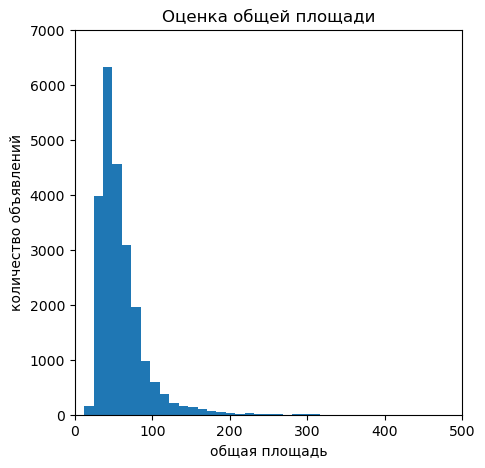

In [28]:
print (realty_df_norm['total_area'].describe())

realty_df_norm.plot (y='total_area', kind='hist', ylim=(0,7000), xlim = (0,500), figsize=(5,5), bins=40, legend = False)
plt.title('Оценка общей площади')
plt.xlabel('общая площадь')
plt.ylabel('количество объявлений')
plt.show()

### Жилая площадь.

Найден 21 странный объект, у которого жилая площадь менее 10 кв.м. из более чем 25 квадратных метров, но взяв во внимание общий тренд на квартиры с большими общими площадями и минимальными жилыми зонами, оставляем в ДФ эти квартиры. Построим гистограмму по данной категории. Средние значения в области 33,5 кв.м. медиана около 30. имеется пики в районе 18-20 и 30 кв.м.,  в ДФ около 30% объектов - однокомнатные и студии, в которых жилая площадь редко превышает 20 кв.м., следующим шагом идут 2-х комнатные квартиры, в которых по статистике средняя жилая площадь около 30-33 кв.м., а так как 1-х и 2-х основная часть квартир в реестре, поэтому мы и наблюдаем 2 пика в соответствии с распределением комнатности.


count    22874.000000
mean        33.581668
std         19.316551
min          0.000000
25%         18.200000
50%         30.000000
75%         42.000000
max        300.000000
Name: living_area, dtype: float64
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


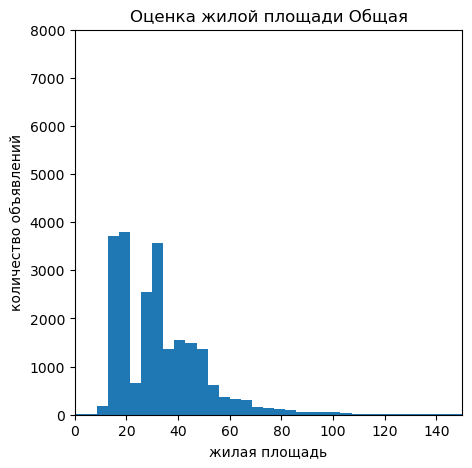

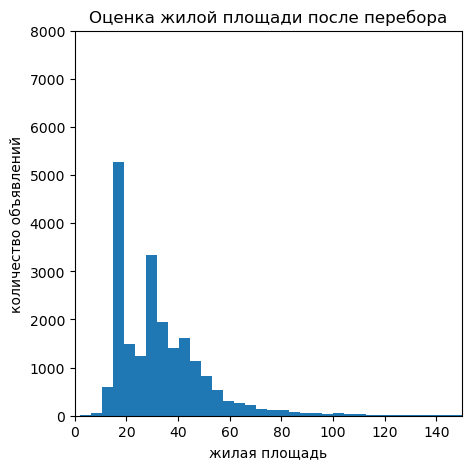

In [29]:
print (realty_df_norm ['living_area'].describe())
live = realty_df_norm.query ('living_area!=0.0 & analysis_apart!=True')
live.query ('living_area<10 & total_area>25').head (25)


print (realty_df_norm.plot (y='living_area', kind='hist', ylim=(0,8000), xlim = (0,150), figsize=(5,5), bins=70, legend = False))
plt.title('Оценка жилой площади Общая')
plt.xlabel('жилая площадь')
plt.ylabel('количество объявлений')
print (live.plot (y='living_area', kind='hist', ylim=(0,8000), xlim = (0,150), figsize=(5,5), bins=70, legend = False))
plt.title('Оценка жилой площади после перебора')
plt.xlabel('жилая площадь')
plt.ylabel('количество объявлений')
plt.show()

### площадь кухни.
Все объекты с площадью кухни равной 0 - студии, это объясняется форматом квартир-студий, они не имеют четкого зонирования с разделением кухонь от остальной площади жилого помещения. Пики в районе 6 и 9 кв.м. могу объяснить спецификой строительства в стране, так как до конца 2000-х по основным типовым объектам строительства (включая период СССР), кухни были или 6\9\12 кв.м.,  но мы видим на графике, что тенденция немного сдвигается в большую сторону, что видно по линии угасания графика после 11 кв.м., пока квартиры с кухнями более 12 кв.м. относительная редкость в общей массе, у верен что данный показатель в новостройках последних 5-7 лет в МСК будет смещен еще существеннее. Медиана в районе 9 кв.м. соответствуют объективным обстоятельствам на рынке.

count    22874.000000
mean        10.238178
std          5.438132
min          0.000000
25%          7.200000
50%          9.000000
75%         11.200000
max        100.700000
Name: kitchen_stat_norm, dtype: float64


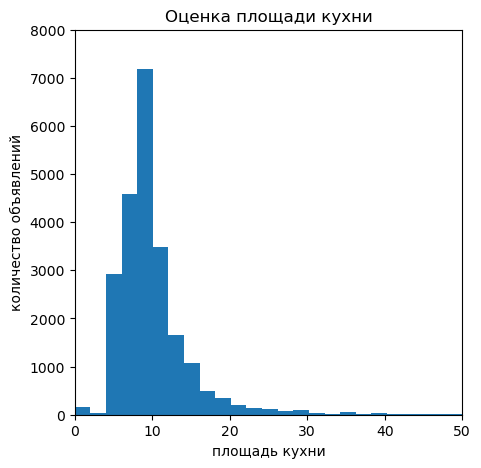

In [30]:
print (realty_df_norm ['kitchen_stat_norm']. describe ())
realty_df_norm.plot (y='kitchen_stat_norm', kind='hist', ylim=(0,8000), xlim = (0,50), figsize=(5,5), bins=50, legend=False)
plt.title('Оценка площади кухни')
plt.xlabel('площадь кухни')
plt.ylabel('количество объявлений')
plt.show()
#zero_kitchen = realty_df_norm.query ('kitchen_stat_norm == 0 ')
#zero_kitchen

### цена объекта
Изучив актуальные предложения в открытых источниках на рынке можно сделать вывод, что ценник на квартиры старого фонда начинаются от 350000. Однако квартира размером 109 квадратов с ценной 12190 явно выбивается из общего формата, как в части размер/цена, а это явно относительно новая квартиры (этажность 20+), так и соответственно в части среднего ценника за квадратный метр. Удалим эту квартиру из выборки. Квартиры стоимостью 85+ млн. как оказалось тоже не редкость, согласно открытым источникам максимальная цена в 2021 году доходила до 800+ млн. в новостройке https://www.fontanka.ru/2021/12/28/70345097/
Но для более комфортного исследования среднестатистической квартиры, полагаю необходимо сделать выборку в пределах коробки с усами. Уберем 000 нуля, для более удобного восприятия. 

Итого, мы получаем медиативную стоимость около 4.5 млн., средняя стоимость выше - 5,9, что объясняется наличием многократно более дорогими квартирами, если ниже средней стоимость у нас минимальная планка всего на 5.5 млн. меньше, то верхняя планка на 60+ млн. выше.  


total_images             295
last_price               295
total_area               295
first_day_exposition     295
rooms                    295
floors_total             295
living_area              295
floor                    295
studio                   295
open_plan                295
balcony                  295
locality_name            295
airports_nearest         295
cityCenters_nearest      295
parks_around3000         295
parks_nearest            295
ponds_around3000         295
ponds_nearest            295
days_exposition          257
analysis_apart           295
ceiling_height_stat      295
kitchen_stat_norm        295
floor_type               295
ration_price_area        295
first_weekday            295
month                    295
year                     295
cityCenters_averag_km    295
dtype: int64

count    22810.000000
mean      5956.522539
std       5237.222993
min        430.000000
25%       3400.000000
50%       4599.000000
75%       6600.000000
max      65850.000000
Name: last_price, dtype: float64


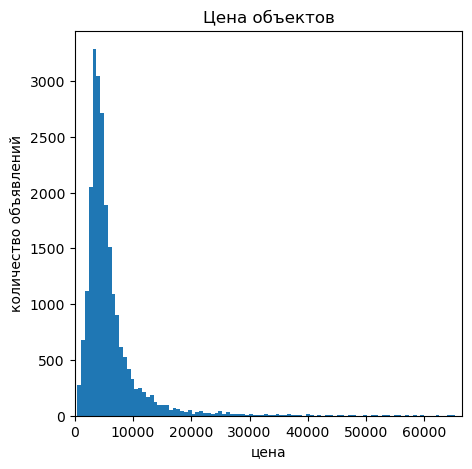

In [31]:
#print (realty_df_norm ['last_price']. describe ())
# новя переменная которая будет использоваться при работе с гистаграммами, realty_df_norm_correct_price, если
realty_stat = realty_df_norm.query ('(last_price > 350000) & (last_price < 66500000)')

realty_df_norm_correct_price_without_zero = realty_stat ['last_price']/1000
display (realty_stat[realty_stat['locality_name']=="гатчина"].count ())
print (realty_df_norm_correct_price_without_zero.describe ())
realty_df_norm_correct_price_without_zero.plot (y='last_price', kind='hist', xlim=(0,66500), figsize=(5,5), bins=100, legend=False)
plt.title('Цена объектов')
plt.xlabel('цена')
plt.ylabel('количество объявлений')
plt.show()

### Срез по средней стоиомсти кв.м.
Важно оценить не только общую стоимость квартир, но и стоимость за квадратный метр, для оценки оставим те же ограничения с общей стоимости. Средняя стоимость и медиана близки около 98000 и 95000 соответственно, но есть объекты, которые выбиваются по минимуму и максиму значительно, посмотрим, что это. Объект стоимостью 28000000 и средней ценной за кв.м. около 848 тыс. размещен 2 раза, в разные дни. учитывая, что это дубль по своей сути, и то, что он попадает в выброс, его можно удалить из анализа. Объекты с стоимостью за кв.м. около 10000 расположены в поселках, часто в Сланцы, имеют площадь около 50 кв.м. а ценна около 500 тыс., Но из этой выборки выбиваются объекты в Гатчине -  1,45 млн за 138 кв.м. и 850000 за 780000 (исключим их из выборки как и дубли выше) Прим. объекты в Гатчине, согласно открытым источникам, должны стоить почти в 10 раз дороже. https://spb.cian.ru/cat.php?deal_type=sale&engine_version=2&location%5B0%5D=174563&mintarea=100&offer_type=flat



count     22762.000000
mean      97742.193388
std       39769.478720
min        7963.000000
25%       76562.500000
50%       94736.800000
75%      113636.400000
max      640422.400000
Name: ration_price_area, dtype: float64

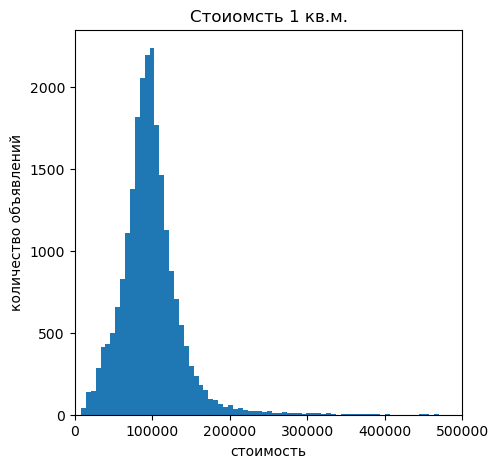

In [32]:

realty_stat = realty_stat.query('last_price!=1450000 & total_area!=138')
realty_stat = realty_stat.query('ration_price_area < 800000').reset_index (drop=True)
display (realty_stat ['ration_price_area'].describe ())

realty_stat.plot (y='ration_price_area', kind='hist', xlim=(0,500000), figsize=(5,5), bins=100, legend=False)
plt.title('Стоиомсть 1 кв.м.')
plt.xlabel('стоимость')
plt.ylabel('количество объявлений')
plt.show()

### количество комнат
Количество комнат, как и высота потолков, этаж квартиры, тип этажа квартиры и общее количество этажей, будут иметь схожие по структуре команды на построение гистограммы (данные в основном категорийные, кроме высоты потолков, хотя и их можно отнести к таковым, так как диапазон значений, довольно ограничен), значит лучше сделать функцию, которая будет вызывать гистограмму

В части оценки объектов по количество комнат, учитывая, что самый распространённый вариант - 1 комната, среднее значение как и медианта - 2, так как 2-х комнатных объектов также большое количество, и за счет объектов с большей комнатностью, среднее и медиана в районе 2-х.


count    22762.000000
mean         2.027722
std          0.998164
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64


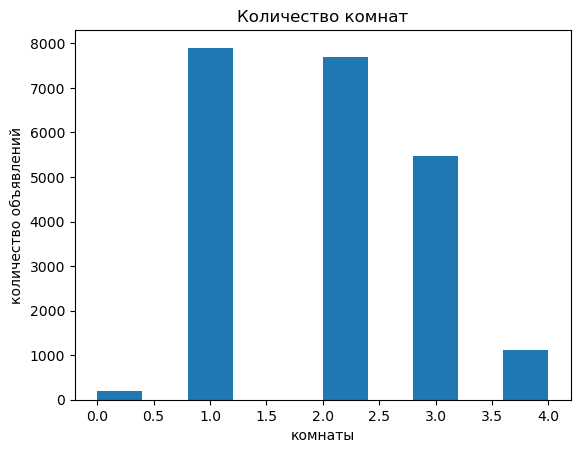

In [33]:
print (realty_stat ['rooms'].describe ())
realty_stat ['rooms'].plot(kind='hist', range=(0,4))
plt.title('Количество комнат')
plt.xlabel('комнаты')
plt.ylabel('количество объявлений')
plt.show()

### высота потолков
медиаативное значение как и среднее соответствует стандартам градостроительства и находится в районе 2.65 м.

count    22762.000000
mean         2.690371
std          0.199628
min          2.300000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.000000
Name: ceiling_height_stat, dtype: float64


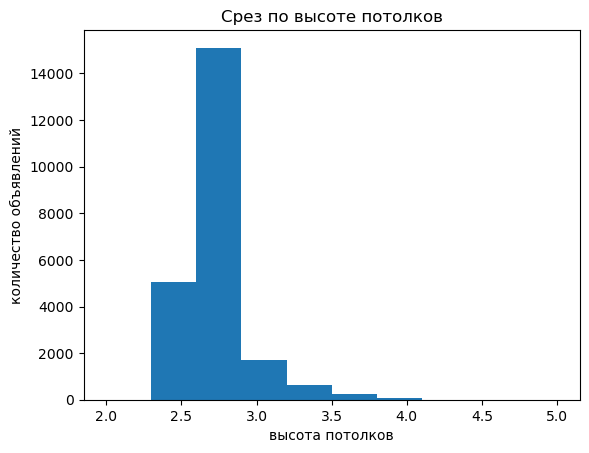

In [34]:
print (realty_stat ['ceiling_height_stat'].describe ())
realty_stat['ceiling_height_stat'].plot(kind='hist', range=(2,5))
plt.title('Срез по высоте потолков')
plt.xlabel('высота потолков')
plt.ylabel('количество объявлений')
plt.show()

### Этаж квартиры
Средняя этажность в районе 6-го этажа, медиана по всем объектам 4-этаж, учитывая, что распространение "хрущовок" которые в основном 5-ти этажные (в районных центрах и остальных поселках), и 9/12 - ти этажные в областных центрах, тенденция понятна. Стоит отметить, что в ДФ присутствуют объекты небольших н.п., которые редко строят выше 5-ти этажей, а также распространение общей тенденции - комфорт-жилья - микрорайоны с этажностью до 9 этажей.

count    22762.000000
mean         5.840392
std          4.829009
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64


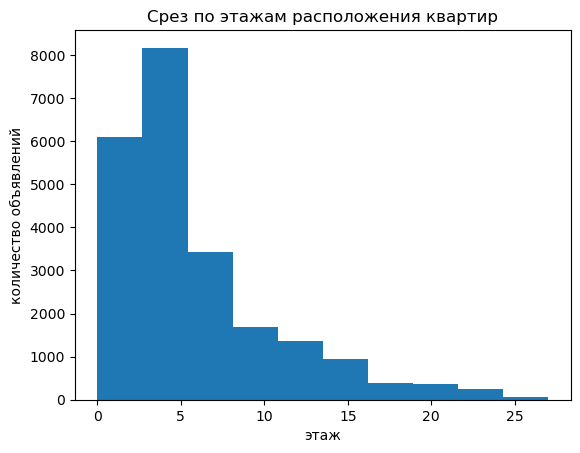

In [35]:
print (realty_stat ['floor'].describe ())
realty_stat['floor'].plot(kind='hist', range=(0,27))
plt.title('Срез по этажам расположения квартир')
plt.xlabel('этаж')
plt.ylabel('количество объявлений')
plt.show()

### Этажность домов
Анализ и выводы озвученные выше в части характерности застройки в 5/9 этажей находят свое подтверждение в гистаграмме.

count    22762.000000
mean        10.651349
std          6.528182
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         28.000000
Name: floors_total, dtype: float64


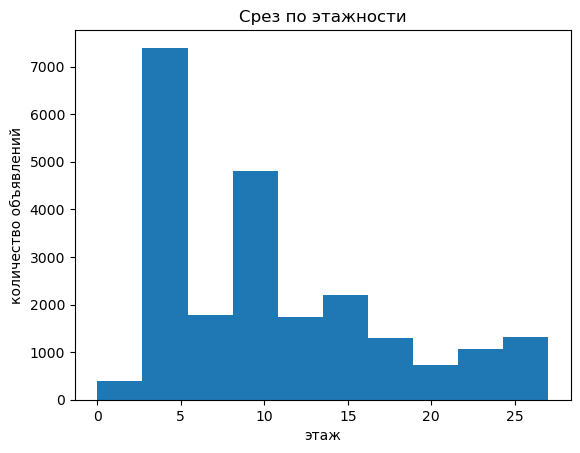

In [36]:
print (realty_stat ['floors_total'].describe ())
realty_stat['floors_total'].plot(kind='hist', range=(0,27))
plt.title('Срез по этажности')
plt.xlabel('этаж')
plt.ylabel('количество объявлений')
plt.show()

### Тип этажа
Вывод очевиден, большинство квартир не, а первом и не на последнем этаже. На что стоит обратить внимание, чуть больше квартир на последнем этаже, чем на первом, во-первых, возможно люди чуть реже выбирают первый этаж, во-вторых, часто на первых этажах находятся организации и коммерческие объекты, и жилые квартиры начинаются со второго.

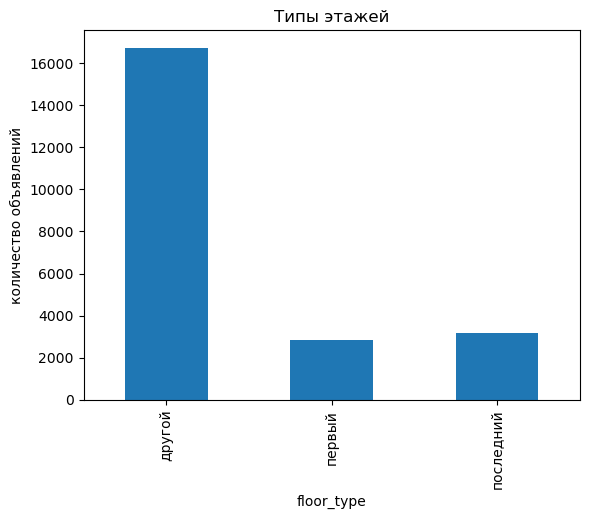

In [37]:
realty_stat ['floor_type'].value_counts().sort_index(ascending=True).plot.bar()
plt.title('Типы этажей')

plt.ylabel('количество объявлений')
plt.show()

### расстояние до центра города в метрах
Учитывая значения заглушки (-77) отсекаем при выборке нижние границы уса, и получаем, что большенство объектов находится на расстоянии 13000-14000 м. от центра города, дальше 20000 м. количество объектов падает.

count    22762.000000
mean      9165.403106
std      11971.313755
min      -7777.000000
25%       2389.500000
50%      11357.000000
75%      15279.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64
count    17493.000000
mean     14268.559910
std       8600.756301
min        181.000000
25%       9421.000000
50%      13140.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


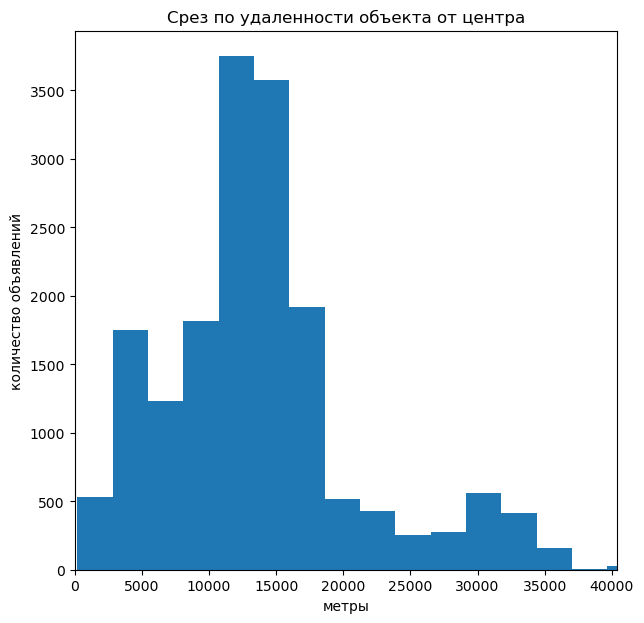

In [38]:
print (realty_stat ['cityCenters_nearest'].describe ())
distance_without_plugs = realty_stat.query ('cityCenters_nearest>0')

print (distance_without_plugs ['cityCenters_nearest'].describe ())

distance_without_plugs.plot (y='cityCenters_nearest', kind='hist', xlim=(0,40400), figsize=(7,7), bins=25, legend=False)
plt.title('Срез по удаленности объекта от центра')
plt.xlabel('метры')
plt.ylabel('количество объявлений')
plt.show()

### расстояние до ближайшего аэропорта.
До аэропорта по статистике дальше, чем до ближайшего центра города, что и логично, количество аэропортов значительно меньше, далеко не в каждом городе есть аэропорт. в среднем аэропорт находится на удалении 28000 м. от объекта

count    22762.000000
mean     22015.717995
std      16526.525504
min        -77.000000
25%      10126.500000
50%      21790.500000
75%      34445.750000
max      84869.000000
Name: airports_nearest, dtype: float64
count    17407.000000
mean     28812.203769
std      12680.604075
min       6450.000000
25%      18488.000000
50%      26773.000000
75%      37347.000000
max      84869.000000
Name: airports_nearest, dtype: float64


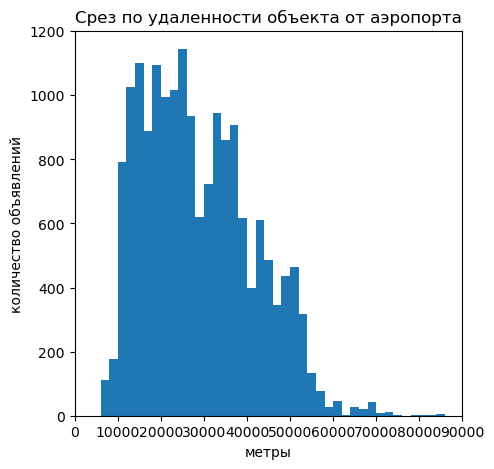

In [39]:
print (realty_stat ['airports_nearest'].describe ())
distance_without_plugs = realty_stat.query ('airports_nearest>0')

print (distance_without_plugs ['airports_nearest'].describe ())

distance_without_plugs.plot (y='airports_nearest', kind='hist', xlim=(0,90000), figsize=(5,5), bins=100, range = (0, 200000), legend=False)
plt.title('Срез по удаленности объекта от аэропорта')
plt.xlabel('метры')
plt.ylabel('количество объявлений')
plt.show()

### расстояние до ближайшего парка
В отличии от центра города и аэропортов, парки находятся достаточно близко, в диапазоне 288-612 метров от объекта. Но нужно учитывать, что значение с данными по парке есть только по 30% объектов, хотя можно с уверенностью можно предположить, что такие элементы инфраструктуры достаточно распространены

count    22762.000000
mean       114.734733
std        334.068345
min        -77.000000
25%        -77.000000
50%        -77.000000
75%        294.000000
max       3190.000000
Name: parks_nearest, dtype: float64
count    7685.000000
mean      490.894079
std       341.953296
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


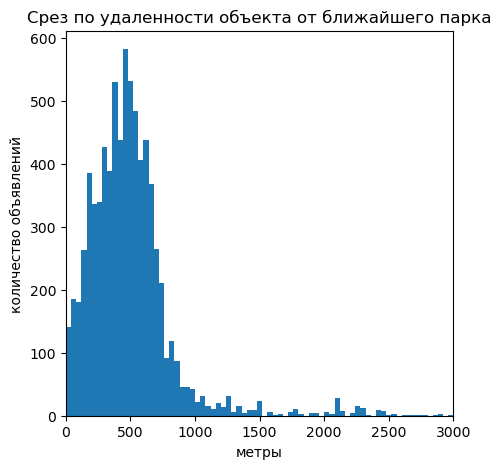

In [40]:
print (realty_stat ['parks_nearest'].describe ())
distance_without_plugs = realty_stat.query ('parks_nearest>0')
print (distance_without_plugs ['parks_nearest'].describe ())

distance_without_plugs.plot (y='parks_nearest', kind='hist', xlim=(0,3000), figsize=(5,5), bins=100, range=(0, 4000), legend=False)
plt.title('Срез по удаленности объекта от ближайшего парка')
plt.xlabel('метры')
plt.ylabel('количество объявлений')
plt.show()

### день и месяц публикации объявления
Основные публикации в средине недели, меньше всего в выходные и понедельник

А выставление объектов на продажу чаще всего в начале года: февраль - апрель, и есть всплеск октябрь-ноябрь. Период февраль - после новогодних праздников, когда много выходных, люди начинают возвращаться в привычный ритм. осень - период после отпусков летних, что также подтверждается снижением количества выставления на продажу летом.


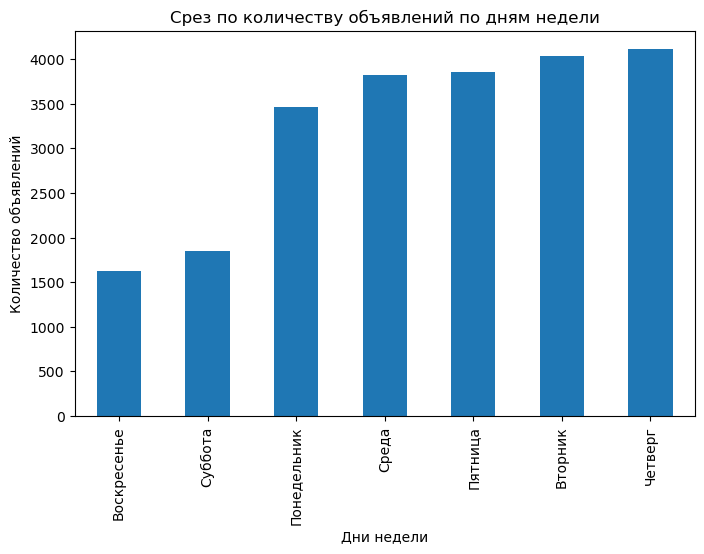

In [41]:
realty_stat.groupby ('first_weekday').agg('count').sort_values (by='total_area').plot (y='total_area', kind='bar', figsize=(8,5), legend=False)

plt.title('Срез по количеству объявлений по дням недели')
plt.xlabel('Дни недели')
plt.ylabel('Количество объявлений')
plt.show()

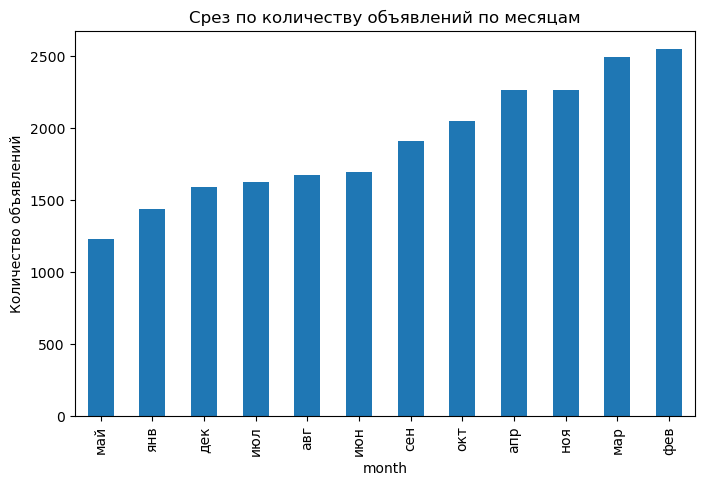

In [42]:
realty_stat.groupby ('month').agg('count').sort_values (by='total_area').plot (y='total_area', kind='bar', figsize=(8,5), legend=False)

plt.title('Срез по количеству объявлений по месяцам')
plt.ylabel('Количество объявлений')
plt.show()


## как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
В основном квартиры продаются в течении 95 дней, среднее время около полугода, быстрыми можно назвать продажи в течении первых 45 дней, а если объявление находится более 7-ми месяцев активным, это уже долгая продажа.

count    19763.000000
mean       179.696757
std        219.076026
min          1.000000
25%         44.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64


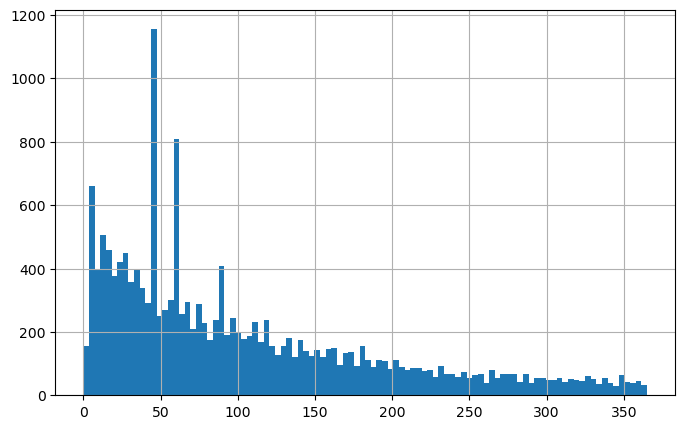

In [43]:
df_days_exposition = realty_stat.query ('days_exposition >=0')
df_days_exposition ['days_exposition'].hist (figsize=(8,5), bins=100, range=(0,365))
print (df_days_exposition ['days_exposition'].describe())

### Какие факторы больше всего влияют на общую (полную) стоимость объекта? 
Проанализируем, какие факторы больше всего влияют на общую (полную) стоимость объекта. Построим графики, которые покажут корреляцию цены от следующих параметров: 
общая площадь, 
жилая площадь, 
площадь кухни, 
количество комнат, 
типа этажа, 
даты размещения (день недели, месяц, год).

Корреляция 0,766. Взаимосвязь между стоимость и площадью имеет место быть

0.765499919214843
AxesSubplot(0.125,0.11;0.775x0.77)


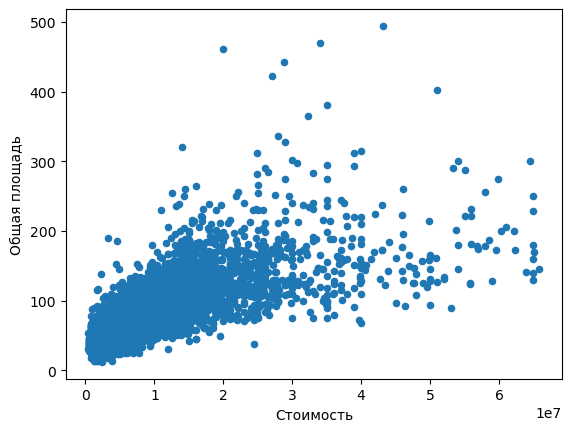

In [44]:
print (realty_stat ['last_price'].corr(realty_stat['total_area']))
print (realty_stat.plot(x='last_price', y='total_area', kind='scatter'))

plt.xlabel('Стоимость')
plt.ylabel('Общая площадь')
plt.show()

немного хуже прослеживается корреляция между жилой площадью и стоиомостью

0.6443985169486374
AxesSubplot(0.125,0.11;0.775x0.77)


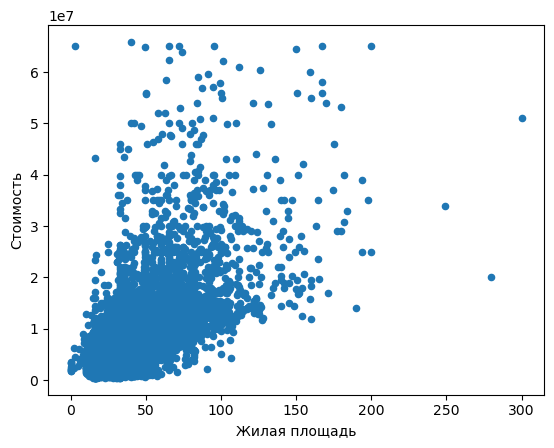

In [45]:
print (realty_stat ['last_price'].corr(realty_stat['living_area'])) 
print (realty_stat.plot(x='living_area', y='last_price', kind='scatter'))
plt.ylabel('Стоимость')
plt.xlabel('Жилая площадь')
plt.show()

Слабая корреляция между стоиостью и размером кухни присутствует

0.5645014456967842
AxesSubplot(0.125,0.11;0.775x0.77)


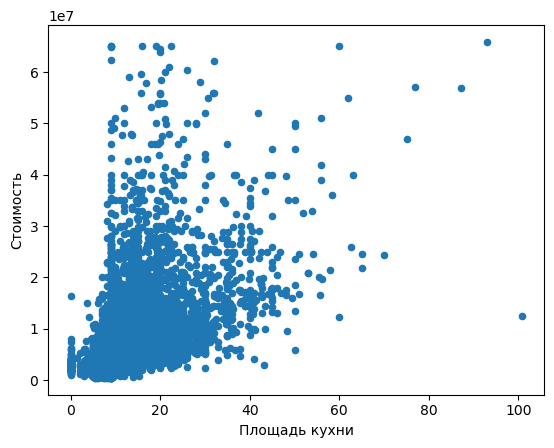

In [46]:
print (realty_stat ['last_price'].corr(realty_stat['kitchen_stat_norm']))
print (realty_stat.plot(x='kitchen_stat_norm', y='last_price', kind='scatter')) 
plt.xlabel('Площадь кухни')
plt.ylabel('Стоимость')
plt.show()

коэффициент корреляции менее 0,5, можем сделать вывод, что она отсуствует

0.470914888898204


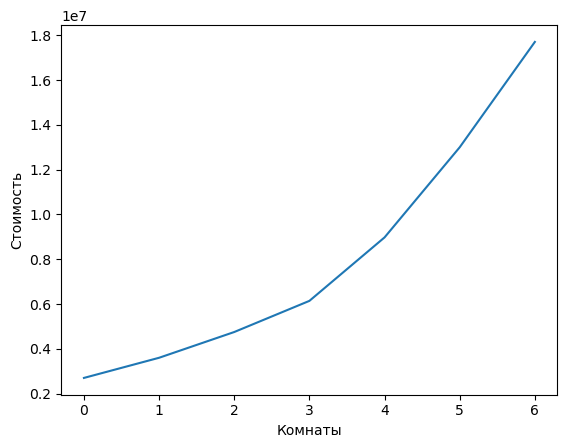

In [47]:
print (realty_stat ['last_price'].corr(realty_stat['rooms']))
realty_stat.groupby('rooms')['last_price'].median().plot()
plt.xlabel('Комнаты')
plt.ylabel('Стоимость')
plt.show()

1-й этаж все же дешевле. Прим. значения не числовые, сделаем сравнение через plt.bar

<BarContainer object of 22762 artists>

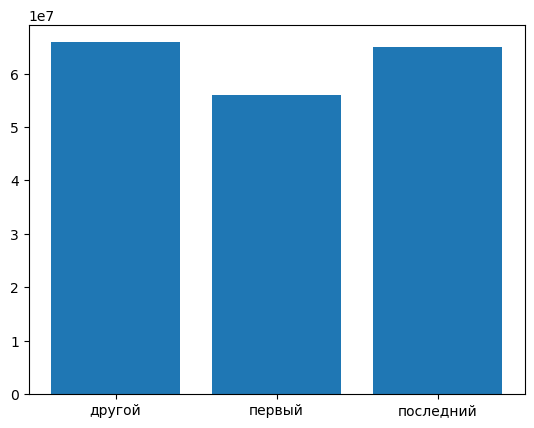

In [48]:
plt.bar (realty_stat['floor_type'], realty_stat ['last_price'])

Явной зависимости нет, но в воскресенье меньше всего поступает на продажу объектов, поэтому просадка

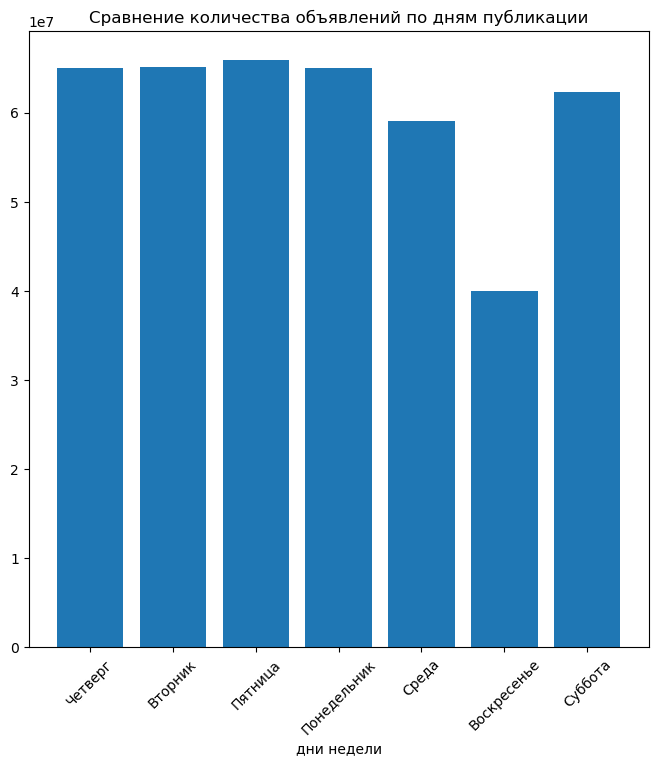

In [49]:
plt.figure (figsize=(8,8))
plt.bar (realty_stat['first_weekday'], realty_stat ['last_price'])
plt.title('Сравнение количества объявлений по дням публикации')
plt.xlabel('дни недели')
plt.xticks (rotation=45)
plt.show()

Явной зависимости нет

<BarContainer object of 22762 artists>

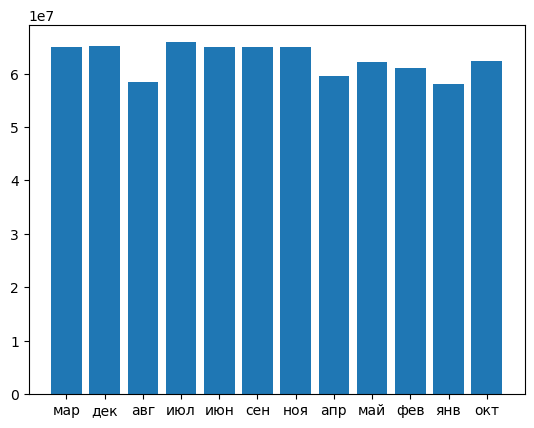

In [50]:
plt.bar (realty_stat['month'], realty_stat ['last_price'])

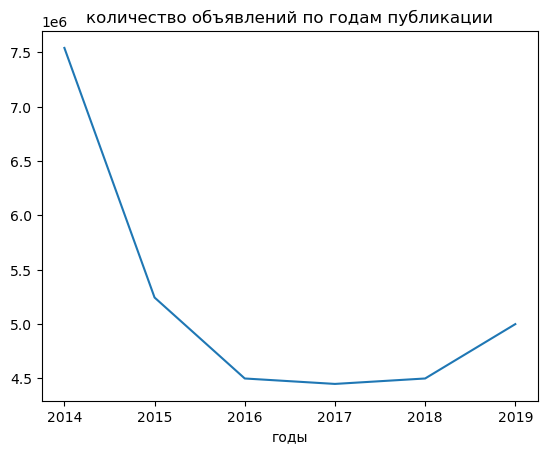

In [51]:

realty_stat.groupby('year')['last_price'].median().plot()
plt.title('количество объявлений по годам публикации')

plt.xlabel('годы')
plt.show()

# Можно утверждать, что на стоимость квартиры больше всего влияет общая и жилая площадь 

## Оценка средней стоимости по населенным пунктам
Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 
Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

Статистика по самым популярным по количеству объявления попали основные н.п. Ленинградской области, где самое больше количество новостроек. 

In [52]:
avg_price_local = pd.pivot_table(realty_stat, index='locality_name', values='ration_price_area', aggfunc={'mean', 'count'})
avg_price_local = avg_price_local.sort_values(by='count', ascending=False)
avg_price_local_group = avg_price_local.head(10)
avg_price_local_group

,count,mean
locality_name,,
санкт-петербург,15073,112432.107935
мурино,571,86112.602277
кудрово,463,95428.074082
шушары,430,78714.891860
всеволожск,384,68702.744531
пушкин,358,102688.684637
колпино,328,75179.654268
парголово,325,90318.187385
гатчина,294,68850.064626


Самый "дорогой" кв.м. в поселке Лисий нос, а самый "дешевый" в послелке ям-тесово

In [53]:
avg_price_local_max = avg_price_local_group.sort_values(by='mean', ascending=False)
print (avg_price_local_max.head(1))

avg_price_local_min = avg_price_local_group.sort_values(by='mean', ascending=True)
print (avg_price_local_min.head(1))


                 count           mean
locality_name                        
санкт-петербург  15073  112432.107935
               count          mean
locality_name                     
выборг           232  58284.751724


Сделаем выборку по городу, и возьмем среднюю цену каждого километра.
Можно сделать вывод, что чем ближе, тем дороже

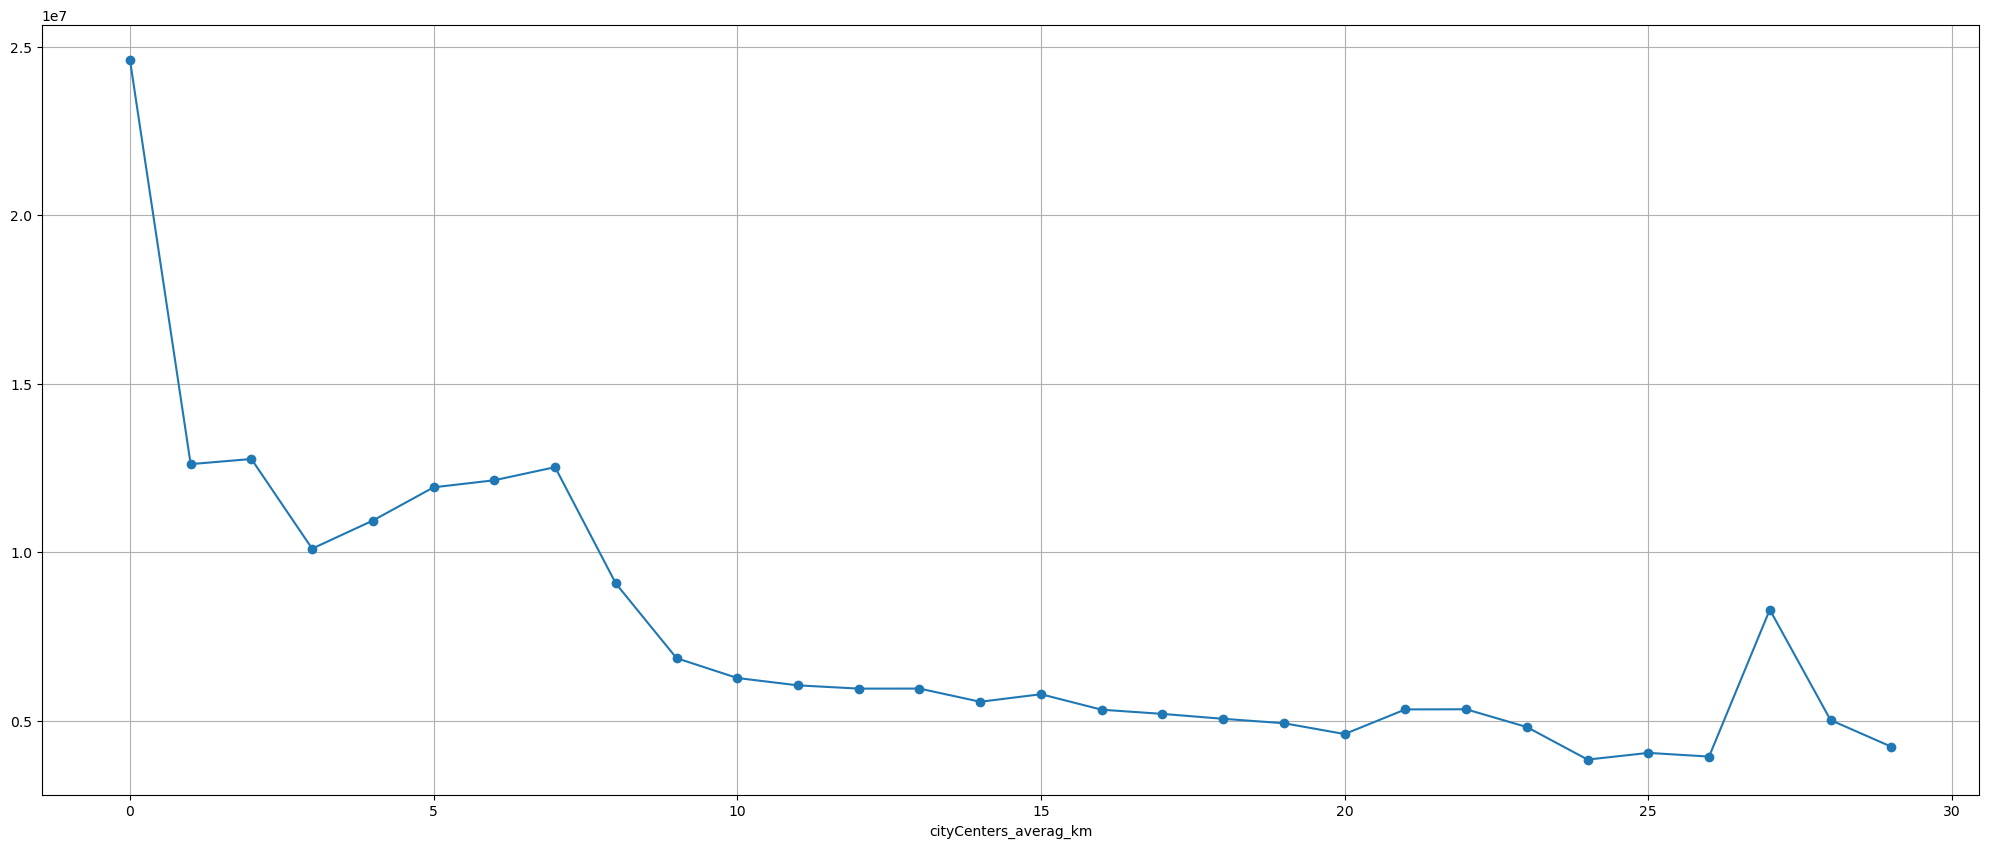

In [54]:
spb_dist = realty_stat[realty_stat['locality_name'] == 'санкт-петербург'].groupby('cityCenters_averag_km')['last_price'].\
mean().plot(grid=True, style='o-',figsize = (25, 10))
#

## Общий вывод


В анализируемом DF в основном 1- и 2-комнтаные квартиры, площадью около 50-59 кв.м., с характерной жилой площадью 1-комнатных– 18-20 кв.м. и 2-комнатых – 30 кв.м.

Основная часть квартир имеет типовую кухню размером 9 кв.м.. Медиативная ценна на такие квартиры в районе 4,5 млн.рублей. 

Потолки в подавляющем большинстве около 2,65 м., что соответствует нормативам, действующим в стране. Основные объявления относятся к квартирам, которые находятся на 4-6 этажах в среднем в 9-10 этажном здании. Первый и последний этаж популярностью не пользуются. 

Расстояние до центра города около 13-14 км., что объясняется застройкой спальных районов. 

До аэропорта около 28 км. 

До парков достаточно близко, большинство объектов находятся на расстоянии от 288 до 600 метров до ближайшего парка.

Самые активные периоды создания объявлений февраль-март и октябрь-ноябрь, что можно в некоторой мере обяснить новогодним периодом и периодом отпусков/дач, после которых люди возвращаются в штатный режим жизни не сразу. Схожая ситуация и с днями недели – в основном объявления загружают в середине недели (среда/четверг).

Средне время продажи – 95 дней, если квартира продается быстрее 45 дней – это очень быстрая продажа, если дольше 158 дней – долгая. 

Основное влияние на стоимость квартиры оказывает общая площадь и  жилая. А в самом Санкт-Петербурге добавляется еще параметр близости к центру города, что объясняется исторической и туристической привлекательностью квартиры (как развитая инфраструктура, объекты культуры, так и потенциал в части сдачи в аренду).

Самая большая цена за квадратный метр из Топ-10 по количеству объявлений  - Санкт-Петербург (в среднем 112 533 руб.за 1 кв.м.), а самая низкая в Выборге – 58 242 рублей за 1 кв.м.


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [ ]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения там, где это возможно
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  устранены неявные дубликаты в названиях населённых пунктов
- [ ]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [ ]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [ ]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [ ]  посчитано и добавлено в таблицу: месяц публикации объявления
- [ ]  посчитано и добавлено в таблицу: год публикации объявления
- [ ]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [ ]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [ ]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [ ]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [ ]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [ ]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [ ]  в каждом этапе есть промежуточные выводы
- [ ]  есть общий вывод